In [1]:
from astropy.modeling import models, fitting
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from scipy import interpolate
import pandas as pd
import sympy as syp
from astropy import units as u
import radio_beam
from astropy.table import Table
from radio_beam import Beam
from astropy import coordinates
from astropy import wcs
from astropy.nddata.utils import Cutout2D
#from dendrocat.aperture import Ellipse
from matplotlib.patches import Rectangle, Ellipse
import regions
from scipy.optimize import curve_fit
from regions import PixCoord, EllipsePixelRegion, EllipseAnnulusPixelRegion
import Paths.Paths as paths
Path = paths.filepaths()




from astropy.table import Table
import matplotlib as mpl
import astropy.units as u
import astropy.constants as c
from lifelines import KaplanMeierFitter
from astropy.stats import mad_std

plt.rcParams['axes.labelsize']=25
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.rcParams['axes.titlesize']=25
mpl.rcParams['axes.linewidth'] = 5
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
params = {"xtick.top": True, "ytick.right": True, "xtick.direction": "in", "ytick.direction": "in"}
plt.rcParams.update(params)


w51e_b3_flux_fits = Table.read(Path.w51e_b3_flux)
w51e_b6_flux_fits = Table.read(Path.w51e_b6_flux)
w51n_b3_flux_fits = Table.read(Path.w51n_b3_flux)
w51n_b6_flux_fits = Table.read(Path.w51n_b6_flux)
w51e_b6_flux_conv_fits = Table.read(Path.w51e_b6_conv_flux)
w51n_b6_flux_conv_fits = Table.read(Path.w51n_b6_conv_flux)

def get_max_size(size_major, size_minor):
    sizearr = []
    idxarr = []
    for i in range(len(size_major)):
        if size_major[i]>size_minor[i]:
            sizearr.append(size_major[i])
        else:
            sizearr.append(size_minor[i])
            idxarr.append(i)
    return np.array(sizearr), np.array(idxarr)

def get_radius(fitsfile, band='b6', index=None, dist_kpc = 5.41):
 
    fits = Table.read(fitsfile)
    major = fits['deconvolved_major_%s'%band]
    minor = fits['deconvolved_minor_%s'%band]
    if index is None:
        index = np.arange(len(major))
    
    avg_size = np.sqrt(major * minor)[index]
    avg_size = np.max((major[index],minor[index]))
    radius_au = avg_size * np.pi/180 * dist_kpc *1000*206264.806 *2/2.355
    return radius_au
def print_idx_value_in_loop(idx, value,label):
    print(label)
    for id, val in zip((idx, value)):
        print(id, val)

catalog_w51e_yso = Table.read(Path.w51e_dendro_matched_catalog,format='fits')
w51e_selected = np.delete(np.arange(137),[121,125,126,130,131,132,134,135,136]) #delete overlapped objects


yso_w51e_xsky_b6 = catalog_w51e_yso['b6_xsky'] ; yso_w51e_ysky_b6 = catalog_w51e_yso['b6_ysky']
yso_w51e_xsky_b3 = catalog_w51e_yso['b3_xsky'] ; yso_w51e_ysky_b3 = catalog_w51e_yso['b3_ysky']

yso_detect_w51e_b6 = np.where(yso_w51e_xsky_b6>0)[0]
yso_detect_w51e_b3 = np.where(yso_w51e_xsky_b3>0)[0]


catalog_w51n_yso = Table.read(Path.w51n_dendro_matched_catalog ,format='fits')
yso_w51n_xsky_b6 = catalog_w51n_yso['b6_xsky'] ; yso_w51n_ysky_b6 = catalog_w51n_yso['b6_ysky']
yso_w51n_xsky_b3 = catalog_w51n_yso['b3_xsky'] ; yso_w51n_ysky_b3 = catalog_w51n_yso['b3_ysky']

yso_xsky_w51e = []
for i,x in enumerate(yso_w51e_xsky_b6):
    if x > 0:
        yso_xsky_w51e.append(x)
    else:
        yso_xsky_w51e.append(yso_w51e_xsky_b3[i])
yso_ysky_w51e = []
for i,x in enumerate(yso_w51e_ysky_b6):
    if x > 0:
        yso_ysky_w51e.append(x)
    else:
        yso_ysky_w51e.append(yso_w51e_ysky_b3[i])

yso_xsky_w51n = []
for i,x in enumerate(yso_w51n_xsky_b6):
    if x > 0:
        yso_xsky_w51n.append(x)
    else:
        yso_xsky_w51n.append(yso_w51n_xsky_b3[i])
yso_ysky_w51n = []
for i,x in enumerate(yso_w51n_ysky_b6):
    if x > 0:
        yso_ysky_w51n.append(x)
    else:
        yso_ysky_w51n.append(yso_w51n_ysky_b3[i])

yso_xysource_w51e= np.vstack((yso_xsky_w51e, yso_ysky_w51e)).T
yso_xysource_w51n= np.vstack((yso_xsky_w51n, yso_ysky_w51n)).T        

#YSO index for indicating whether they are inside core boundary or not
isincore_w51e_b3 = catalog_w51e_yso['inincore_b3fov'] 
isincore_w51n_b3 = catalog_w51n_yso['inincore_b3fov'] 
isoutcore_w51e_b3 = np.where(~catalog_w51e_yso['inincore_b3fov'])[0] 
isoutcore_w51n_b3 = np.where(~catalog_w51n_yso['inincore_b3fov'])[0] 


# For b6, need to combine isincore index with isoverlap index
isincore_w51e_b6 = np.intersect1d(np.where(catalog_w51e_yso['inincore_b3fov']), np.where(catalog_w51e_yso['is_overlap'])) 
isincore_w51n_b6 = np.intersect1d(np.where(catalog_w51n_yso['inincore_b3fov']), np.where(catalog_w51n_yso['is_overlap'])) 
isoutcore_w51e_b6 = np.intersect1d(np.where(~catalog_w51e_yso['inincore_b3fov']), np.where(catalog_w51e_yso['is_overlap'])) 
isoutcore_w51n_b6 = np.intersect1d(np.where(~catalog_w51n_yso['inincore_b3fov']), np.where(catalog_w51n_yso['is_overlap'])) 

iscore_ff_w51e = [41, 46, 48, 50, 51, 54, 56, 8, 9, 10, 85, 119, 25]
iscore_ff_w51n = [61, 3, 6, 7, 23, 29, 70, 71, 72, 52]



isoutcore_w51e_b3 = [i for i in list(isoutcore_w51e_b3) if i not in iscore_ff_w51e]
isoutcore_w51n_b3 = [i for i in list(isoutcore_w51n_b3) if i not in iscore_ff_w51n]
isoutcore_w51e_b6 = [i for i in list(isoutcore_w51e_b6) if i not in iscore_ff_w51e]
isoutcore_w51n_b6 = [i for i in list(isoutcore_w51n_b6) if i not in iscore_ff_w51n]

hdrB6_w51e_almaimf = fits.getheader(Path.w51e_b6_almaimf)  
wcsB6_w51e_almaimf = WCS(hdrB6_w51e_almaimf,naxis=2)
beamb6_w51e_almaimf = Beam.from_fits_header(hdrB6_w51e_almaimf)  
scale_w51e_b6_almaimf = wcsB6_w51e_almaimf.proj_plane_pixel_scales()[0]


hdrB3_w51e_almaimf = fits.getheader(Path.w51e_b3_almaimf)  
wcsB3_w51e_almaimf = WCS(hdrB3_w51e_almaimf,naxis=2)
beamb3_w51e_almaimf = Beam.from_fits_header(hdrB3_w51e_almaimf) 

hdrB6_w51n_almaimf = fits.getheader(Path.w51n_b6_almaimf)  
wcsB6_w51n_almaimf = WCS(hdrB6_w51n_almaimf,naxis=2)
beamb6_w51n_almaimf = Beam.from_fits_header(hdrB6_w51n_almaimf)  

hdrB3_w51n_almaimf = fits.getheader(Path.w51n_b3_almaimf)  
wcsB3_w51n_almaimf = WCS(hdrB3_w51n_almaimf,naxis=2)
beamb3_w51n_almaimf = Beam.from_fits_header(hdrB3_w51n_almaimf) 

fitsdata_almaimf_w51e_b6 = fits.open(Path.w51e_b6_almaimf)
image_almaimf_w51e_b6 = fitsdata_almaimf_w51e_b6[0].data
if len(image_almaimf_w51e_b6.shape)>2:
    image_almaimf_w51e_b6 = fitsdata_almaimf_w51e_b6[0].data[0][0]
xysource_pix_w51e_almaimf = wcsB6_w51e_almaimf.all_world2pix(yso_xysource_w51e,0)

fitsdata_b3 = fits.open(Path.w51e_b3_tt0)
image_b3_w51e = fitsdata_b3[0].data
if len(image_b3_w51e.shape)>2:
    image_b3_w51e = fitsdata_b3[0].data[0][0]
hdrB3_w51e_hr = fits.getheader(Path.w51e_b3_tt0) 
wcsB3_w51e_hr = WCS(hdrB3_w51e_hr,naxis=2)
scale_w51e_b3_hr = wcsB3_w51e_hr.proj_plane_pixel_scales()[0] 
beam_b3_w51e = Beam.from_fits_header(hdrB3_w51e_hr)
    
fitsdata_b3 = fits.open(Path.w51n_b3_tt0)
image_b3_w51n = fitsdata_b3[0].data
if len(image_b3_w51n.shape)>2:
    image_b3_w51n = fitsdata_b3[0].data[0][0]
hdrB3_w51n_hr = fits.getheader(Path.w51n_b3_tt0) 
wcsB3_w51n_hr = WCS(hdrB3_w51n_hr,naxis=2)
scale_w51n_b3_hr = wcsB3_w51n_hr.proj_plane_pixel_scales()[0]
beam_b3_w51n = Beam.from_fits_header(hdrB3_w51n_hr)

fitsdata_b6 = fits.open(Path.w51e_b6_cont)
image_b6_w51e = fitsdata_b6[0].data
if len(image_b6_w51e.shape)>2:
    image_b6_w51e = fitsdata_b6[0].data[0][0]
hdrB6_w51e_hr = fits.getheader(Path.w51e_b6_cont)  
wcsB6_w51e_hr = WCS(hdrB6_w51e_hr,naxis=2)
scale_w51e_b6_hr = wcsB6_w51e_hr.proj_plane_pixel_scales()[0]
beam_b6_w51e = Beam.from_fits_header(hdrB6_w51e_hr)

fitsdata_b6 = fits.open(Path.w51n_b6_cont)
image_b6_w51n = fitsdata_b6[0].data
if len(image_b6_w51n.shape)>2:
    image_b6_w51n = fitsdata_b6[0].data[0][0]
hdrB6_w51n_hr = fits.getheader(Path.w51n_b6_cont)  
wcsB6_w51n_hr = WCS(hdrB6_w51n_hr,naxis=2)
scale_w51n_b6_hr = wcsB6_w51n_hr.proj_plane_pixel_scales()[0]
beam_b6_w51n = Beam.from_fits_header(hdrB6_w51n_hr)

def get_sigma(data, xsky,ysky,afwhm, bfwhm, angle):
    print(xsky,ysky,afwhm,bfwhm,angle)
    region_sigma = EllipsePixelRegion(center=PixCoord(xsky,ysky), width=afwhm, height=bfwhm, angle=angle*u.deg)
    source_mask = region_sigma.to_mask()
    source_mask_cutout = source_mask.cutout(data)
    print(source_mask_cutout.shape)
    mad = mad_std(source_mask_cutout, ignore_nan=True)

    return mad



1062.1483515381885 803.3868668251816 4.552972192564489 3.3364507059251323 -45.90349197388
(5, 5)
1066.3481954697693 835.1202208643933 4.552972192564489 3.3364507059251323 -45.90349197388
(5, 5)
1047.0815307776716 834.720126097349 4.552972192564489 3.3364507059251323 -45.90349197388
(5, 5)
1045.4148565691453 836.2534512352755 4.552972192564489 3.3364507059251323 -45.90349197388
(5, 5)
1123.0814920461778 842.5871665715777 4.552972192564489 3.3364507059251323 -45.90349197388
(5, 5)
1047.4813648678755 868.4534614409807 4.552972192564489 3.3364507059251323 -45.90349197388
(5, 5)
1045.748030221369 868.7201195818824 4.552972192564489 3.3364507059251323 -45.90349197388
(5, 5)
1044.6145519602715 898.1867807033728 4.552972192564489 3.3364507059251323 -45.90349197388
(5, 5)
999.3478757915253 900.119891377049 4.552972192564489 3.3364507059251323 -45.90349197388
(5, 5)
981.2145398368409 900.6531355095378 4.552972192564489 3.3364507059251323 -45.90349197388
(5, 5)
998.214536884185 901.2532191360647 

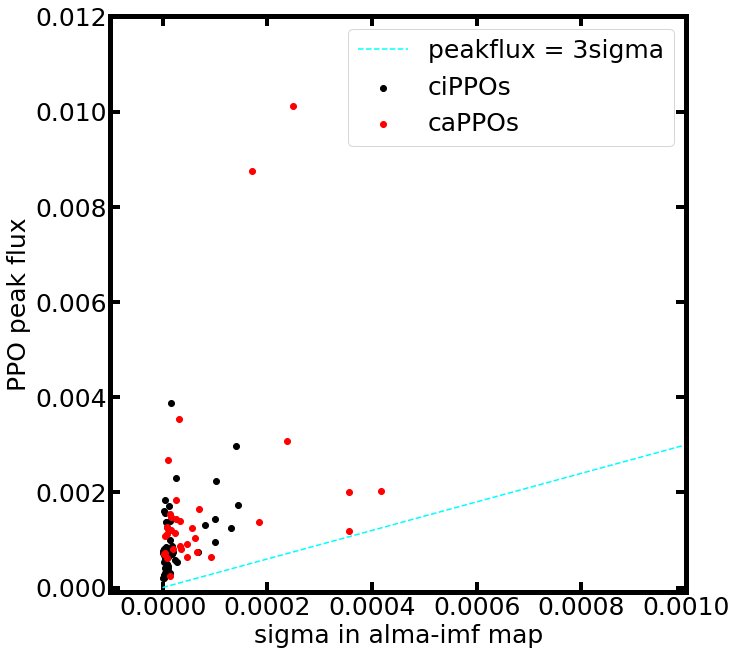

In [18]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
for ind in isoutcore_w51e_b6:
    mad = get_sigma(image_almaimf_w51e_b6, xysource_pix_w51e_almaimf[ind,0],xysource_pix_w51e_almaimf[ind,1],
                    (10*beam_b6_w51e.major/scale_w51e_b6_almaimf).value, (10*beam_b6_w51e.minor/scale_w51e_b6_almaimf).value, beam_b6_w51e.pa.value)
    ax1.scatter(mad*(beam_b6_w51e.major*beam_b6_w51e.minor/beamb6_w51e_almaimf.major/beamb6_w51e_almaimf.minor), catalog_w51e_yso['peak_flux_b6'][ind],c='k')
for ind in isincore_w51e_b6:
    mad = get_sigma(image_almaimf_w51e_b6, xysource_pix_w51e_almaimf[ind,0],xysource_pix_w51e_almaimf[ind,1],
                    (10*beam_b6_w51e.major/scale_w51e_b6_almaimf).value, (10*beam_b6_w51e.minor/scale_w51e_b6_almaimf).value, beam_b6_w51e.pa.value)
    ax1.scatter(mad*(beam_b6_w51e.major*beam_b6_w51e.minor/beamb6_w51e_almaimf.major/beamb6_w51e_almaimf.minor), catalog_w51e_yso['peak_flux_b6'][ind],c='r')
ax1.set_xlabel('sigma in alma-imf map')
ax1.set_ylabel('PPO peak flux')
ax1.plot([0,0.001],[0,0.001*3],c='cyan',ls='dashed',label='peakflux = 3sigma')
ax1.set_ylim(-1e-4,0.012)

ax1.set_xlim(-1e-4,0.001)
ax1.scatter([-99,-99],[-99,-99], c='k',label='ciPPOs')
ax1.scatter([-99,-99],[-99,-99], c='r',label='caPPOs')
ax1.legend(fontsize=25)